In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce
from scipy import stats as stats
from sklearn.impute import KNNImputer
import json
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Section 1: Buniness Understanding

I would like to know if one should be doing Airbnb or Long-term rental in Seattle. The main questions are:

### Q1: Is Airbnb more profitable than rent in general?
### Q2: How to become a good host of Airbnb?
### Q3: Is there a particular season during the year that one should concentrate on?

## Section 2: Data Understanding

Since we will be comparing the Airbnb data with rental data, let's look at them separately. The rental data is easier to handle, let's start from that.

### Section 2.1: The rent data

The idea is to convert the fair market rents (FMR) from the U.S. Department of Housing and Urban Development (HUD) to an estimate of rent for a given zipcode and number of bedrooms. It's given for each zipcode and number of bedroom. To avoid making this notebook too long and side-tracking, it's prepared in the check-rent.ipynb notebook. We will just load them in here.

In [2]:
rent_ref = pd.read_csv('rent_ref.csv')
rent_ref.set_index('zip_code', inplace=True)
rent_ref = rent_ref.iloc[:,-5:]
rent_ref.columns = [0.0, 1.0, 2.0, 3.0, 4.0]
rent_ref = rent_ref.stack().reset_index()
rent_ref.columns = ['zipcode', 'bedrooms', 'rent']
rent_ref['zipcode'] = rent_ref['zipcode'].astype(str)
rent_ref

,zipcode,bedrooms,rent
0,98119,0.0,1108.800
1,98119,1.0,1247.400
2,98119,2.0,1334.025
3,98119,3.0,1663.200
4,98119,4.0,2205.000
...,...,...,...
130,98125,0.0,982.800
131,98125,1.0,1108.800
132,98125,2.0,1190.700
133,98125,3.0,1483.650


### Section 2.2: The Airbnb data

This data can be downloaded from the kaggle website, as suggested in the project description. 

In [3]:
listings = pd.read_csv('seattle_airbnb_data.dir/listings.csv')
reviews = pd.read_csv('seattle_airbnb_data.dir/reviews.csv')
calendar = pd.read_csv('seattle_airbnb_data.dir/calendar.csv')

In [4]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
listings.last_scraped.value_counts()

2016-01-04    3818
Name: last_scraped, dtype: int64

In [6]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [7]:
reviews.date.min(), reviews.date.max()

('2009-06-07', '2016-01-03')

In [8]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [9]:
calendar.date.min(), calendar.date.max()

('2016-01-04', '2017-01-02')

In [10]:
listings.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

#### It's important to see that, the listings and reviews are up to 2016-01-04, but the calendar is from this date onwards. This means the existing data are likely history data, but the calendar reflects the "future" when it was scraped. I am going to focus on 2015 data, that's closest to the time frmae in calendar file. 

#### I have also decided to focus on the listings that rent out the entire home/apt. This is because 1) it is easier to compare with the rental data which are specified according to the number of bedrooms and zipcode; 2) the available vs not available dates in the calendar file are more likely reflecting the actual occupied rate of guests, as the hosts may block-out certain dates if they live in the shared property for their own usage 

## Section 3: Data Preparation

The main thing here is to come up with an estimate of revenue from the Airbnb dataset. Here's the plan:
<ul>
<li> 
    Multiply the averaged nightly price with the average number of reviews, which we do it in two ways:
    <ul>
    <li> 1. Estimate this for every month. This is because of the time varying signal we will see in. This first way also involves imputing the monthly price table. The difficult part here is we have a lot of NaNs in the monthly estimate for both the nightly price and review counts. I used KNN to impute the price table. The best n_neighbors is decided in a separate notebook check-impute-month-price.ipynb. I decided to simply fillna(0) on the review counts, see some justifaction below. </li>
    <li> 2. Use yearly estimated value, which is fairly straightforward </li>
    </ul>
    The 1st method is preferred, as the 2nd method means imputing the NaN in review counts using the mean, which may overestimate the revenue, see Section .
</li>
<li> 
    Inflate this number with the estimated portion of guests that leave review (50-75%), average length of stays (3-4 nights) and the tax/fee (20-30%) that taken out from airbnb host. These numbers can be found on 
    <a href=http://insideairbnb.com/data-assumptions>Inside Airbnb</a>, 
    <a href=https://commissions.sfplanning.org/cpcpackets/2014-001033PCA.pdf>SF planning report</a>,
    travel booking/info site like
    <a href=https://www.momondo.com/hotels/seattle>this</a>,
    <a href=https://travellemming.com/seattle-travel-tips/#:~:text=3%2D4%20days%20is%20a,one%20day%20in%20Seattle%20itinerary.>this</a>, and
    <a href=https://www.kayak.com/Seattle-Hotels.7054.hotel.ksp#:~:text=The%20cheapest%203%2Dstar%20hotel,in%20Seattle%20for%203%20days.>this</a>
</li>
</ul>
For plotting, I downloaded a zip boundary json file from <a href=https://github.com/OpenDataDE/State-zip-code-GeoJSON/tree/master>here</a>, and simply use matplotlib patch to plot the polygons. See ZipPlotter class in this notebook for details.
</html>

I think this is the most most rewarding part. The original file is in Q1--revenue-vs-rent.ipynb, and I reassemble it here.

### Section 3.1: Initial filter and combine
This is to make sure the year range, room type, and property type are the same for the three main part of the analysis: the listing itself, the monthly price from the caldendar, and the reviews

In [1]:
def filter_and_combine():
    '''
      filter and combine the raw data together, work directly on global dataframe
    '''
    condition_1 = (listings.room_type == 'Entire home/apt')
    condition_2 = (listings.property_type.isin(['House','Apartment','Townhouse','Condominium','Loft']))
    condition_3 = listings.first_review.apply(lambda x: int(x.split('-')[0])<=2015 if isinstance(x,str) else False)
    condition_4 = listings.last_review.apply(lambda x: int(x.split('-')[0])>=2015 if isinstance(x,str) else False)
    condition_5 = (listings.bedrooms <= 4)
    listings_filtered = listings.loc[ condition_1 & condition_2 & condition_3 & condition_4 & condition_5, 
                                     ['id','zipcode','bedrooms','first_review','last_review','reviews_per_month', 'host_since']].copy()
    
    # filtered the calendar so it has the same listing_id
    calendar_filtered = calendar[calendar.available == 't'].copy()                                  
    calendar_filtered['price'] = calendar_filtered['price'].str.lstrip('\$').replace('\,','',regex=True).astype(float)
    calendar_filtered['month'] = calendar_filtered.date.apply(lambda x: x.split('-')[1])
                                     
    month_price = calendar_filtered.groupby(['listing_id','month']).agg({'price':'mean'}).unstack(level=1)
    month_price.columns = month_price.columns.get_level_values(1)
    month_price = pd.merge(left = listings_filtered[['id']],
                           right = month_price,
                           left_on = 'id',
                           right_on = 'listing_id',
                           how = 'left')
    month_price.set_index('id', inplace=True)
    
    # calculate the relative value in month_price for time varying plot
    mean = month_price.mean(axis=1)
    month_price_relative = month_price.sub(mean, axis=0).div(mean, axis=0)
    
    # add the yearly average price to listings
    avg_price = calendar_filtered.groupby(['listing_id']).agg({'price':'mean'})
    avg_price.columns = ['avg_price']
    listings_filtered = pd.merge(left = listings_filtered,
                                 right = avg_price,
                                 left_on = 'id',
                                 right_on = 'listing_id',
                                 how = 'left')
    
    # deal with review
    reviews['yr'] = reviews.date.apply(lambda x:x.split('-')[0])
    reviews['month'] = reviews.date.apply(lambda x:x.split('-')[1])
    reviews_filtered = reviews[reviews.yr=='2015'].copy()
    review_counts = reviews_filtered.groupby(['listing_id','month']).agg({'id':'count'}).unstack(level=1)
    review_counts.columns = review_counts.columns.get_level_values(1)
    review_counts = pd.merge(left = listings_filtered[['id']],
                             right = review_counts,
                             left_on = 'id',
                             right_on = 'listing_id',
                             how = 'left')
    review_counts.set_index('id', inplace=True)
    
    # update the first review, last review in the listings
    first_last_review = reviews_filtered.groupby(['listing_id']).agg({'date':['min','max']})
    first_last_review.columns = ['first_review_2015', 'last_review_2015']
    listings_filtered = pd.merge(left = listings_filtered,
                                 right = first_last_review,
                                 left_on = 'id',
                                 right_on = 'listing_id',
                                 how = 'left')
    
    # get the avg reviews per month on listings
    listings_filtered['total_reviews'] = review_counts.sum(axis=1).values
    listings_filtered['delta_days'] = pd.to_datetime(listings_filtered.last_review_2015) \
                                        - pd.to_datetime(listings_filtered.first_review_2015)
    listings_filtered['delta_days'] = listings_filtered['delta_days'].apply(lambda x: x.days)
    listings_filtered['reviews_per_month_2015'] = (listings_filtered['total_reviews'] - 1) / listings_filtered['delta_days'] * 30
    idx = (listings_filtered['delta_days'] <= 30)
    listings_filtered.loc[idx, 'reviews_per_month_2015'] = listings_filtered.loc[idx, 'total_reviews']
    
    return listings_filtered, month_price, month_price_relative, review_counts

In [12]:
listings_filtered, month_price, month_price_relative, review_counts = filter_and_combine()

In [13]:
listings_filtered.head()

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,host_since,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,2011-08-11,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,2013-02-21,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,2011-11-29,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,2013-02-21,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,2010-09-19,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356


In [14]:
month_price.head()

,01,02,03,04,05,06,07,08,09,10,11,12
id,,,,,,,,,,,,
241032,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.0,85.000000,85.000000,85.000000
953595,164.266667,NaN,154.000000,154.566667,169.645161,193.600000,197.193548,192.935484,170.6,141.645161,128.400000,192.387097
278830,516.666667,465.517241,456.451613,458.333333,456.451613,456.666667,458.064516,456.451613,457.5,457.258065,456.666667,458.064516
2493658,198.625000,127.200000,142.935484,154.566667,169.645161,193.600000,197.193548,192.935484,170.6,141.645161,128.400000,192.387097
175576,NaN,NaN,NaN,95.000000,94.600000,92.777778,95.000000,95.000000,NaN,95.000000,95.000000,95.000000


In [15]:
review_counts.head()

,01,02,03,04,05,06,07,08,09,10,11,12
id,,,,,,,,,,,,
241032,4.0,8.0,7.0,4.0,7.0,8.0,6.0,4.0,7.0,1.0,7.0,5.0
953595,NaN,1.0,5.0,6.0,3.0,5.0,NaN,4.0,6.0,2.0,1.0,1.0
278830,1.0,1.0,NaN,1.0,3.0,3.0,4.0,NaN,1.0,2.0,NaN,NaN
2493658,1.0,NaN,NaN,NaN,NaN,1.0,NaN,4.0,4.0,4.0,4.0,2.0
175576,NaN,NaN,NaN,3.0,5.0,10.0,8.0,6.0,7.0,4.0,5.0,NaN


### Section 3.2: Compare the reviews_per_month in entire history vs the reviews_per_month_2015

Text(0, 0.5, 'reviews per month in 2015')

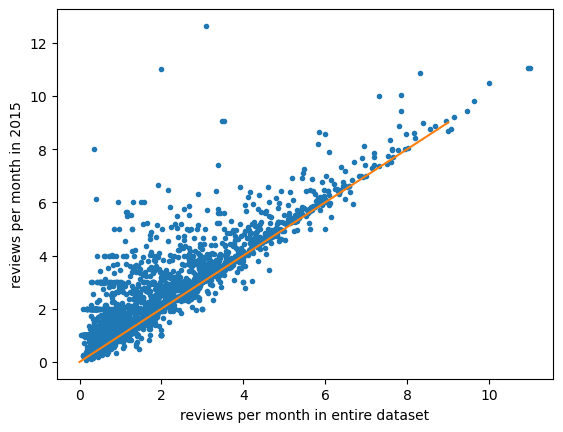

In [16]:
plt.plot(listings_filtered.reviews_per_month, listings_filtered.reviews_per_month_2015, '.')
xtmp = np.arange(0, 10); ytmp = xtmp; plt.plot(xtmp, ytmp, '-')
plt.xlabel('reviews per month in entire dataset')
plt.ylabel('reviews per month in 2015')

#### somewhat surprising that the two are actually comparable, with 2015 only slightly better; which means the growth rate of Airbnb may start to plateau as in 2015

### Section 3.2: Now the fun part is to estimate the revenue/profit using two methods

In [17]:
month_price_imputed = pd.DataFrame(KNNImputer(n_neighbors=10).fit_transform(month_price),
                                   columns = month_price.columns, index = month_price.index)
month_price_imputed

,01,02,03,04,05,06,07,08,09,10,11,12
id,,,,,,,,,,,,
241032,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.00000,85.000000,85.000000,85.000000
953595,164.266667,149.604674,154.000000,154.566667,169.645161,193.600000,197.193548,192.935484,170.60000,141.645161,128.400000,192.387097
278830,516.666667,465.517241,456.451613,458.333333,456.451613,456.666667,458.064516,456.451613,457.50000,457.258065,456.666667,458.064516
2493658,198.625000,127.200000,142.935484,154.566667,169.645161,193.600000,197.193548,192.935484,170.60000,141.645161,128.400000,192.387097
175576,93.550000,93.854052,92.887097,95.000000,94.600000,92.777778,95.000000,95.000000,94.95000,95.000000,95.000000,95.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
262764,184.090909,183.965517,184.032258,185.000000,195.000000,195.000000,195.000000,203.774194,211.00000,190.319355,187.666667,190.125806
8578490,57.500000,55.000000,68.000000,71.096667,81.666667,106.538462,65.000000,65.000000,65.00000,65.000000,65.000000,65.000000
3383329,95.000000,95.000000,101.000000,107.454545,108.777778,113.333333,110.172414,111.260870,104.62963,95.000000,95.000000,95.000000


In [18]:
listings_filtered['monthly_proxy_revenue_method_1'] = (review_counts.fillna(0) * month_price_imputed).sum(axis=1).values / 12
listings_filtered['monthly_proxy_revenue_method_2'] = listings_filtered['avg_price'] * listings_filtered['reviews_per_month']

Text(0, 0.5, 'method 2')

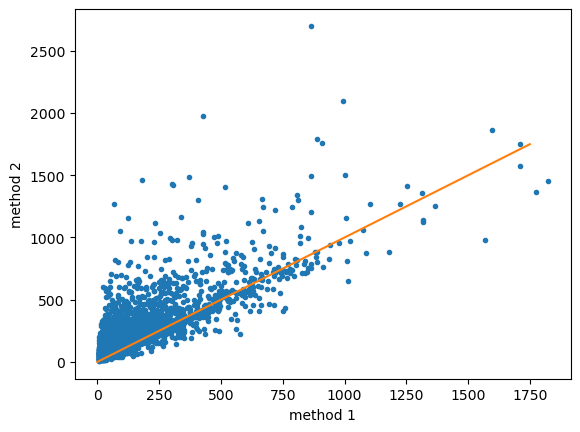

In [19]:
plt.plot(listings_filtered.monthly_proxy_revenue_method_1, listings_filtered.monthly_proxy_revenue_method_2, '.')
xtmp = np.arange(0,1750); ytmp = xtmp; plt.plot(xtmp, ytmp, '-')
plt.xlabel('method 1'); plt.ylabel('method 2')

#### As advertised, method 2 is somewhat higher, especially when the revenue is small; this is as expected, because essentially it fills nan with mean, instead of zero as in method 1. We will stick with method 1 for now.

### Technical note 1: is imputing the price matrix okay for the first method?
This is checked more carefully in check-impute-month-price notebook. The main conclusion is that the cross-validation fit is about 10-12 dollars in terms of median absolute error, this is fairly small and suggest we can safely imputing the matrix

### Technical note 2: is fillna(0) in the review counts okay for the first method?
To be specific, if a hosting just starts in the middle of the year, it will produce real NaN before the starting date. Vice versa, if a hosting shuts down, it will produce real NaN after the starting date. Is this really happening?

In [2]:
def get_start_month(x):
    ''' helper funtion to get the first month in 2015 for date array x'''
    yr, month, _ = x.split('-')
    if yr < '2015':
        return '01'
    elif yr > '2015':
        return '13'
    else:
        return month

def get_last_month(x):
    ''' helper funtion to get the first month in 2015 for date array x '''
    yr, month, _ = x.split('-')
    if yr < '2015':
        return '00'
    elif yr > '2015':
        return '12'
    else:
        return month

In [21]:
host_since_month = listings_filtered.host_since.apply(get_start_month).astype(int)
first_review_month = listings_filtered.first_review.apply(get_start_month).astype(int)
last_review_month = listings_filtered.last_review.apply(get_last_month).astype(int)
months_between_reviews = last_review_month - first_review_month

<AxesSubplot:>

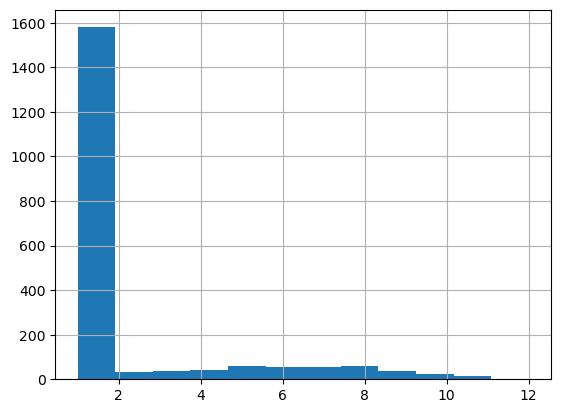

In [22]:
host_since_month.hist(bins=12)

<AxesSubplot:>

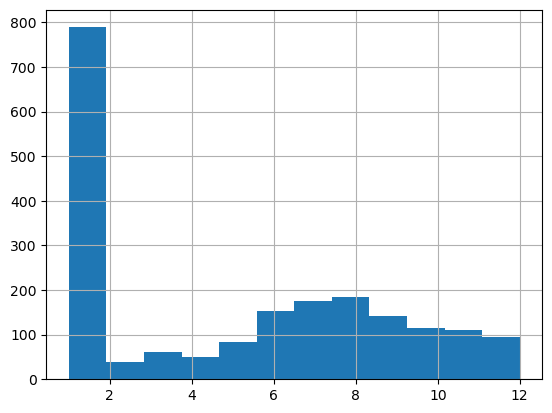

In [23]:
first_review_month.hist(bins=12)

<AxesSubplot:>

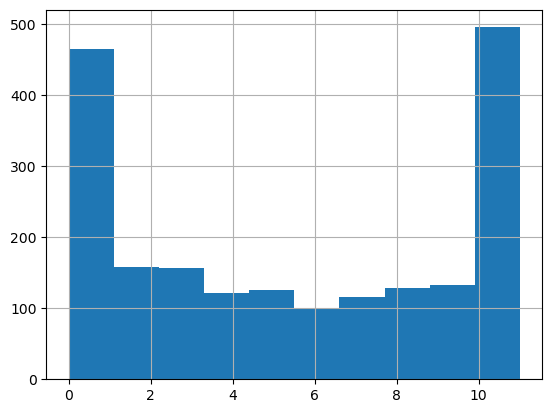

In [24]:
months_between_reviews.hist()

#### Observation (a): so looks like the majority of host was already hosting since January, plus, we do see a lot of reviews started coming in in january. These two means many hosts were indeed "working" for the entire year. More importantly, this suggests very few just started in 2015, which would have real NaNs before their starting dates. 
#### The bump in the summar is likely real and reflects the fact that there are more tourists in the summer. However, the histogram of month bewteen the first and last reviews looks bimodal and has a lot of 0s and 11s. The 0s implies there're listings simply do not have a lot of reviews. The 11s means the listings are likely operating for the entire year, not shutting down in the middle which would have produced NaN after the shutdown dates.
#### The conclusion here is that most listings are likely operating for the entire year, and the NaN in the middle are not real NaN and more likely means there is no review.

<AxesSubplot:xlabel='mean_counts', ylabel='na_counts'>

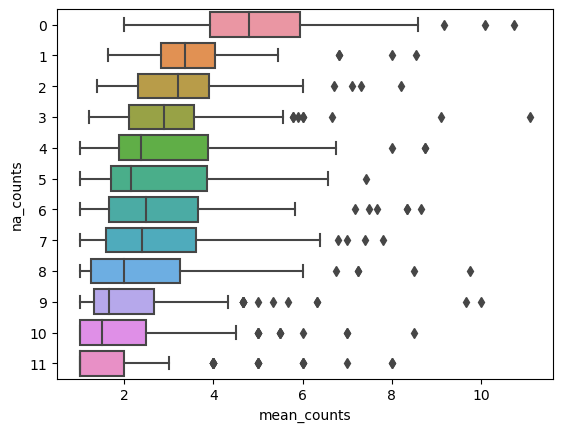

In [25]:
na_counts = review_counts.isna().sum(axis=1)
tmp = pd.DataFrame()
tmp['mean_counts'] = review_counts.mean(axis=1).values
tmp['na_counts'] = na_counts.values.astype('str')
sns.boxplot(data=tmp, y='na_counts', x='mean_counts', order=[str(i) for i in range(12)])

#### Observation (b): the na_counts has some dependence on the mean_counts, which means hosts with fewer reviews tend to have more nans. This means even with we fill the nan as 0, we are not losing that much.

#### So together with Observation (a), I think fillna(0) is okay.

### Section 3.3: Inflate the proxy to estimate the profit, merge with rent and so some diff calculations

In [26]:
listings_filtered['monthly_profit_low_end'] = listings_filtered['monthly_proxy_revenue_method_1'] * 3 / 0.75 * 0.3
listings_filtered['monthly_profit_high_end'] = listings_filtered['monthly_proxy_revenue_method_1'] * 4 / 0.5 * 0.2

In [27]:
listings_filtered = pd.merge(left = listings_filtered,
                             right = rent_ref,
                             left_on = ['zipcode', 'bedrooms'], right_on=['zipcode','bedrooms'],
                             how = 'left')

In [28]:
listings_filtered

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,host_since,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015,monthly_proxy_revenue_method_1,monthly_proxy_revenue_method_2,monthly_profit_low_end,monthly_profit_high_end,rent
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,2011-08-11,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972,481.666667,345.950000,578.000000,770.666667,1247.40
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,2013-02-21,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028,476.946626,252.978282,572.335951,763.114602,1247.40
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,2011-11-29,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836,615.345523,411.838356,738.414627,984.552836,1663.20
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,2013-02-21,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318,275.943481,260.318673,331.132177,441.509570,1247.40
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,2010-09-19,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356,377.952315,315.697059,453.542778,604.723704,1247.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103,2.0,2015-10-01,2015-12-27,1.56,2011-11-07,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310,78.841487,298.977093,94.609785,126.146380,1389.15
1994,8578490,98103,1.0,2015-10-01,2015-10-16,0.63,2014-02-01,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000,10.833333,42.703167,13.000000,17.333333,1297.80
1995,3383329,98107,1.0,2014-07-08,2015-12-29,4.01,2012-09-01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667,463.099153,412.303449,555.718984,740.958645,1297.80
1996,8101950,98107,3.0,2015-09-27,2015-09-27,0.30,2015-04-13,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000,31.229167,107.700000,37.475000,49.966667,1738.80


In [29]:
listings_filtered['better_airbnb_high_end'] = (listings_filtered['monthly_profit_high_end'] > listings_filtered['rent'])
listings_filtered['better_airbnb_low_end'] = (listings_filtered['monthly_profit_low_end'] > listings_filtered['rent'])
listings_filtered

,id,zipcode,bedrooms,first_review,last_review,reviews_per_month,host_since,avg_price,first_review_2015,last_review_2015,total_reviews,delta_days,reviews_per_month_2015,monthly_proxy_revenue_method_1,monthly_proxy_revenue_method_2,monthly_profit_low_end,monthly_profit_high_end,rent,better_airbnb_high_end,better_airbnb_low_end
0,241032,98119,1.0,2011-11-01,2016-01-02,4.07,2011-08-11,85.000000,2015-01-03,2015-12-24,68.0,355,5.661972,481.666667,345.950000,578.000000,770.666667,1247.40,False,False
1,953595,98119,1.0,2013-08-19,2015-12-29,1.48,2013-02-21,170.931271,2015-02-15,2015-12-29,34.0,317,3.123028,476.946626,252.978282,572.335951,763.114602,1247.40,False,False
2,278830,98119,3.0,2012-07-10,2015-10-24,0.89,2011-11-29,462.739726,2015-01-04,2015-10-24,16.0,293,1.535836,615.345523,411.838356,738.414627,984.552836,1663.20,False,False
3,2493658,98119,1.0,2014-04-27,2015-12-20,1.55,2013-02-21,167.947531,2015-01-02,2015-12-20,20.0,352,1.619318,275.943481,260.318673,331.132177,441.509570,1247.40,False,False
4,175576,98119,1.0,2011-07-21,2015-11-25,3.33,2010-09-19,94.803922,2015-04-20,2015-11-25,48.0,219,6.438356,377.952315,315.697059,453.542778,604.723704,1247.40,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,98103,2.0,2015-10-01,2015-12-27,1.56,2011-11-07,191.651982,2015-10-01,2015-12-27,5.0,87,1.379310,78.841487,298.977093,94.609785,126.146380,1389.15,False,False
1994,8578490,98103,1.0,2015-10-01,2015-10-16,0.63,2014-02-01,67.782805,2015-10-01,2015-10-16,2.0,15,2.000000,10.833333,42.703167,13.000000,17.333333,1297.80,False,False
1995,3383329,98107,1.0,2014-07-08,2015-12-29,4.01,2012-09-01,102.818815,2015-01-03,2015-12-29,54.0,360,4.416667,463.099153,412.303449,555.718984,740.958645,1297.80,False,False
1996,8101950,98107,3.0,2015-09-27,2015-09-27,0.30,2015-04-13,359.000000,2015-09-27,2015-09-27,1.0,0,1.000000,31.229167,107.700000,37.475000,49.966667,1738.80,False,False


## Section 4: Modeling
We are intereted in fitting the difference in terms of profit between Airbnb and rental and figuring out which features are more important than the others. The EDA part is done in Q2--what makes it a good listing--EDA.ipynb, which is fairly lengthy and it's better to keep it as a separate file and focus on the modeling here. The file also specify how to determine good/bad/strange amentities. 

The original file for modeling is Q2--modeling.ipynb, and I reassembled it here. At first, I tried including zip code and bedrooms in the fitting, but the feature importance plot is way too long, as we have many zipcodes (please see the original notebook)! More importantly, it is not saying too much, with zip code/bedrooms being the most important things, which we already know from the EDA. Therefore, in this assembled notebook, I am going to take the mean (calculated for each zip code/bedroom combination) out. This is actually a better question to ask: **<u> What can we do to better compete with peers in the same zip code and having the same number of bedroom? </u>**

### Section 4.1: Pickout the more useful features

In [30]:
listings_filtered['monthly_profit_diff_high_end'] = listings_filtered['monthly_profit_high_end'] - listings_filtered['rent']

In [31]:
cols_tofit = ['id', 'monthly_profit_diff_high_end']
cols = ['id',         
        'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',        
        'host_response_rate', 'host_is_superhost', 'host_response_time', 'host_about',
        'first_review',
        'cancellation_policy', 'instant_bookable', 'extra_people', 'price',
        'amenities',
        'property_type', 'bedrooms', 'zipcode', 'transit']
combine = pd.merge(left = listings_filtered[cols_tofit],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine.head()

,id,monthly_profit_diff_high_end,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,host_is_superhost,host_response_time,host_about,first_review,cancellation_policy,instant_bookable,extra_people,price,amenities,property_type,bedrooms,zipcode,transit
0,241032,-476.733333,10.0,10.0,10.0,10.0,96%,f,within a few hours,"I am an artist, interior designer, and run a s...",2011-11-01,moderate,f,$5.00,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Apartment,1.0,98119,NaN
1,953595,-484.285398,10.0,10.0,10.0,10.0,98%,t,within an hour,Living east coast/left coast/overseas. Time i...,2013-08-19,strict,f,$0.00,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Apartment,1.0,98119,"Convenient bus stops are just down the block, ..."
2,278830,-678.647164,9.0,9.0,10.0,10.0,100%,f,within an hour,"Hi, I live in Seattle, Washington but I'm orig...",2012-07-10,strict,f,$15.00,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",House,3.0,98119,The nearest public transit bus (D Line) is 2 b...
3,2493658,-805.890430,10.0,10.0,10.0,10.0,98%,t,within an hour,Living east coast/left coast/overseas. Time i...,2014-04-27,strict,f,$0.00,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Apartment,1.0,98119,"Convenient bus stops are just down the block, ..."
4,175576,-642.676296,10.0,10.0,10.0,10.0,100%,t,within a few hours,Eileen and Ray were born in Seattle just three...,2011-07-21,moderate,f,$15.00,$95.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",House,1.0,98119,The bus stop is just two blocks from our house...


In [32]:
combine['host_response_rate'] = combine['host_response_rate'].str.strip('%').astype(float)

## whether the host has some words about themselves
combine['has_host_about'] = np.where(~combine['host_about'].isna(), 't', 'f')
combine.drop(columns=['host_about'], inplace=True)

# how many days since the first review came in, a proxy for the time length of this hosting
combine['first_review_days'] = (pd.to_datetime('2016-01-01') - pd.to_datetime(combine['first_review'])).apply(lambda x: x.days)
combine.drop(columns=['first_review'], inplace=True)

# combine the fee for extra people and the price listed by the host in the listing file
combine['extra_people'] = combine['extra_people'].str.strip('$').astype(float)
combine['price'] = combine['price'].str.strip('$').astype(float)

# check out the transit type
pat = re.compile('(\W|^)(bus|buses)(\W|$)')
combine['transit_type'] = combine['transit'].apply(lambda x: 'bus' if isinstance(x, str) and pat.search(x.lower()) else 'other')
combine.loc[combine.transit.isna(), 'transit_type'] = 'not_provided'
combine.drop(columns=['transit'], inplace=True)

# going to treat bedrooms as category
combine['bedrooms'] = combine['bedrooms'].astype(str)

# some work on amenities
good_ones = ['Doorman', 'Hair Dryer', 'Laptop Friendly Workspace', 'Iron', 'Heating',
             '24-Hour Check-in', 'Shampoo', 'Hangers', 'Essentials', 'Essentials']
bad_ones = ['Indoor Fireplace', 'Hot Tub', 'Washer']
strange_ones = ['Free Parking on Premises', 'Family/Kid Friendly']
combine['amenities_unpacked'] = combine['amenities'].apply(lambda x: set(re.sub('[\{\}\"]', '', x).split(',')))
combine['good_amenities_counts'] = 0
combine['bad_amenities_counts'] = 0
combine['strange_amenities_counts'] = 0
for thing in good_ones:
    combine['good_amenities_counts'] += combine['amenities_unpacked'].apply(lambda x: thing in x).astype(int)
for thing in bad_ones:
    combine['bad_amenities_counts'] += combine['amenities_unpacked'].apply(lambda x: thing in x).astype(int)
for thing in strange_ones:
    combine['strange_amenities_counts'] += combine['amenities_unpacked'].apply(lambda x: thing in x).astype(int)
combine.drop(columns=['amenities_unpacked','amenities'], inplace=True)

# the has pet is from the reviews
pat = re.compile(r'(\W|^)(cat|kitten|dog|puppy)(\W|$)')
reviews['has_pet'] = reviews.comments.apply(lambda x: True if (isinstance(x,str) and pat.search(x.lower())) else False)
tmp = reviews.groupby('listing_id').agg({'has_pet':any})
combine = pd.merge(left=combine, right=tmp, left_on='id', right_on='listing_id', how='left')
combine['has_pet'] = np.where(combine['has_pet'], 't', 'f')

combine

,id,monthly_profit_diff_high_end,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,host_is_superhost,host_response_time,cancellation_policy,...,property_type,bedrooms,zipcode,has_host_about,first_review_days,transit_type,good_amenities_counts,bad_amenities_counts,strange_amenities_counts,has_pet
0,241032,-476.733333,10.0,10.0,10.0,10.0,96.0,f,within a few hours,moderate,...,Apartment,1.0,98119,t,1522,not_provided,1,1,1,t
1,953595,-484.285398,10.0,10.0,10.0,10.0,98.0,t,within an hour,strict,...,Apartment,1.0,98119,t,865,bus,3,1,2,f
2,278830,-678.647164,9.0,9.0,10.0,10.0,100.0,f,within an hour,strict,...,House,3.0,98119,t,1270,bus,4,0,1,f
3,2493658,-805.890430,10.0,10.0,10.0,10.0,98.0,t,within an hour,strict,...,Apartment,1.0,98119,t,614,bus,3,1,2,f
4,175576,-642.676296,10.0,10.0,10.0,10.0,100.0,t,within a few hours,moderate,...,House,1.0,98119,t,1625,bus,9,1,1,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,9.0,8.0,10.0,10.0,100.0,f,within an hour,strict,...,House,2.0,98103,t,92,bus,8,1,1,f
1994,8578490,-1280.466667,9.0,8.0,10.0,10.0,100.0,f,within a few hours,moderate,...,Apartment,1.0,98103,f,92,bus,4,2,0,f
1995,3383329,-556.841355,10.0,10.0,10.0,10.0,100.0,t,within an hour,moderate,...,Apartment,1.0,98107,t,542,bus,9,2,2,f
1996,8101950,-1688.833333,8.0,10.0,4.0,8.0,99.0,f,within a few hours,strict,...,House,3.0,98107,f,96,not_provided,4,1,2,f


#### Finally we are here

### Section 4.2: One more thing, the NaNs!

In [33]:
combine.shape

(1998, 23)

In [34]:
combine.isna().sum()

id                                0
monthly_profit_diff_high_end      3
review_scores_accuracy           18
review_scores_cleanliness        16
review_scores_checkin            18
review_scores_communication      15
host_response_rate              187
host_is_superhost                 0
host_response_time              187
cancellation_policy               0
instant_bookable                  0
extra_people                      0
price                             0
property_type                     0
bedrooms                          0
zipcode                           3
has_host_about                    0
first_review_days                 0
transit_type                      0
good_amenities_counts             0
bad_amenities_counts              0
strange_amenities_counts          0
has_pet                           0
dtype: int64

In [35]:
# this is so few, let's just drop the data
combine.dropna(subset=['monthly_profit_diff_high_end', 'zipcode'], axis=0, inplace=True)

In [36]:
# fill with median for the rest
for col in ['review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 'host_response_rate']:
    x = combine[col].median()
    print(x)
    combine[col].fillna(x, inplace=True)

10.0
10.0
10.0
10.0
100.0


In [37]:
combine['host_response_time'].value_counts()

within an hour        950
within a few hours    530
within a day          313
a few days or more     15
Name: host_response_time, dtype: int64

In [38]:
combine['host_response_time'].fillna('within an hour', inplace=True)

In [39]:
combine.isna().sum(), combine.shape

(id                              0
 monthly_profit_diff_high_end    0
 review_scores_accuracy          0
 review_scores_cleanliness       0
 review_scores_checkin           0
 review_scores_communication     0
 host_response_rate              0
 host_is_superhost               0
 host_response_time              0
 cancellation_policy             0
 instant_bookable                0
 extra_people                    0
 price                           0
 property_type                   0
 bedrooms                        0
 zipcode                         0
 has_host_about                  0
 first_review_days               0
 transit_type                    0
 good_amenities_counts           0
 bad_amenities_counts            0
 strange_amenities_counts        0
 has_pet                         0
 dtype: int64,
 (1995, 23))

### Technical notes on NaNs:
- There are only 3 NaNs in'monthly_profit_diff_high_end' and 'zipcode', so dropping them is unlikely to cause any trouble.
- For the scores, the medians are in fact the highest possible score (10), which suggest they are not superuseful as so many guests tend to leave full scores. This is also later confirmed by the feature importance plot. Filling them with median should be fine. There are only 1% of them too, so I won't worry too much about them.
- For 'host_response_time', it's a categorical feature with "within an hour" the most frequent value, and I decide to fill it with this value. There're ~10% of them missing, it's not a very small portion so may need some caution later on. 


### Section 4.3 Make dummies
When doing linear modeling, it's important to drop one column when making dummies to avoid linear dependence. While most people will choose to drop first, I choose to drop the one with most counts. This is for better inrepretation, i.e. what needs to be changed compared to what most of the other people are doing in order to make more profit.

In [3]:
def make_dummies(dat):
    '''
       create dummy variables for each object type in the dataframe
       input: 
         dat: data frame
       output:
         dat: data frame with dummies
       some notes:
         if the column is a t vs f, drop f
         otherwise dropping the most common when making dummies
    '''
    def _join(col, val):
        return '_'.join(['dummy', col, val])
    
    cols_cat = dat.columns[dat.dtypes == 'object']
    cols_to_drop = []
    cols_to_rename = {}
    for col in cols_cat:
        tmp = dat[col].value_counts().sort_values(ascending=False)
        if set(tmp.index) == {'t','f'}:
            cols_to_drop.append(_join(col, 'f'))
        else:
            val_ref = tmp.index[0]
            cols_to_drop.append(_join(col, val_ref))
            for val in tmp.index[1:]:
                cols_to_rename[_join(col, val)] = _join(col, val) + '_vs_' + val_ref
                
    dat = pd.get_dummies(dat,
                         columns = cols_cat,
                         prefix = ['dummy_'+x for x in cols_cat])
    dat = dat.drop(columns=cols_to_drop)
    print(dat.columns)
    print(cols_to_rename)
    dat.columns = [cols_to_rename[x] if x in cols_to_rename else x for x in list(dat.columns)]
    return dat

In [41]:
# take out the mean for given zipcode/bedroom combination and make dummies
dat = combine.drop(columns=['id']).copy()

In [42]:
tmp = dat.groupby(['zipcode','bedrooms']).agg({'monthly_profit_diff_high_end':'mean'})
tmp.reset_index(inplace=True)
tmp.columns = ['zipcode','bedrooms','mean']

In [43]:
dat = pd.merge(left=dat, right=tmp, how='left',
               left_on = ['zipcode','bedrooms'],
               right_on = ['zipcode','bedrooms'])

In [44]:
dat['monthly_profit_diff_high_end_demean'] = dat['monthly_profit_diff_high_end'] - dat['mean']
dat.drop(columns=['monthly_profit_diff_high_end', 'mean','zipcode','bedrooms'], inplace=True)

In [45]:
dat = make_dummies(dat)
dat

Index(['review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'host_response_rate', 'extra_people', 'price', 'first_review_days',
       'good_amenities_counts', 'bad_amenities_counts',
       'strange_amenities_counts', 'monthly_profit_diff_high_end_demean',
       'dummy_host_is_superhost_t',
       'dummy_host_response_time_a few days or more',
       'dummy_host_response_time_within a day',
       'dummy_host_response_time_within a few hours',
       'dummy_cancellation_policy_flexible',
       'dummy_cancellation_policy_moderate', 'dummy_instant_bookable_t',
       'dummy_property_type_Condominium', 'dummy_property_type_House',
       'dummy_property_type_Loft', 'dummy_property_type_Townhouse',
       'dummy_has_host_about_t', 'dummy_transit_type_not_provided',
       'dummy_transit_type_other', 'dummy_has_pet_t'],
      dtype='object')
{'dummy_host_response_time_within a few hours': 'dummy_host_response_time_wi

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,extra_people,price,first_review_days,good_amenities_counts,bad_amenities_counts,...,dummy_cancellation_policy_moderate_vs_strict,dummy_instant_bookable_t,dummy_property_type_Condominium_vs_Apartment,dummy_property_type_House_vs_Apartment,dummy_property_type_Loft_vs_Apartment,dummy_property_type_Townhouse_vs_Apartment,dummy_has_host_about_t,dummy_transit_type_not_provided_vs_bus,dummy_transit_type_other_vs_bus,dummy_has_pet_t
0,10.0,10.0,10.0,10.0,96.0,5.0,85.0,1522,1,1,...,1,0,0,0,0,0,1,1,0,1
1,10.0,10.0,10.0,10.0,98.0,0.0,150.0,865,3,1,...,0,0,0,0,0,0,1,0,0,0
2,9.0,9.0,10.0,10.0,100.0,15.0,450.0,1270,4,0,...,0,0,0,1,0,0,1,0,0,0
3,10.0,10.0,10.0,10.0,98.0,0.0,150.0,614,3,1,...,0,0,0,0,0,0,1,0,0,0
4,10.0,10.0,10.0,10.0,100.0,15.0,95.0,1625,9,1,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,9.0,8.0,10.0,10.0,100.0,50.0,154.0,92,8,1,...,0,0,0,1,0,0,1,0,0,0
1991,9.0,8.0,10.0,10.0,100.0,0.0,65.0,92,4,2,...,1,0,0,0,0,0,0,0,0,0
1992,10.0,10.0,10.0,10.0,100.0,8.0,95.0,542,9,2,...,1,1,0,0,0,0,1,0,0,0
1993,8.0,10.0,4.0,8.0,99.0,0.0,359.0,96,4,1,...,0,0,0,1,0,0,0,1,0,0


### Section 4.4 Linear Regression

In [4]:
def preprocess(dat, y_col):
    '''
       preprocess the data frame dat using StandardScaler
       input: 
         dat: dataframe
         y_col: the column for y, which is the variable to fit
       output:
         X:  the scaled version of the data, note that we don't scale the dummy variables
         y:  the y to be fitted later
         cols:  the name of columns corresponding to X
    '''
    cols_cat, cols_num = [], []
    for col in dat.columns:
        if col.startswith('dummy'):
            cols_cat.append(col)
        else:
            cols_num.append(col)
    cols_num.remove(y_col)
    X1 = dat[cols_num].values
    X2 = dat[cols_cat].values
    y = dat[y_col].values
    X1 = StandardScaler().fit_transform(X1)
    X = np.concatenate((X1, X2), axis=1)
    return X, y, cols_num + cols_cat

In [47]:
X, y, cols = preprocess(dat, 'monthly_profit_diff_high_end_demean')

In [48]:
reg = GridSearchCV(Ridge(), param_grid={'alpha':np.arange(100)}, scoring='neg_mean_absolute_error')
reg.fit(X, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='neg_mean_absolute_error')

In [49]:
reg.cv_results_

{'mean_fit_time': array([0.00142899, 0.00191083, 0.00120907, 0.00118437, 0.00133419,
        0.00111485, 0.00111666, 0.00113258, 0.00105805, 0.00123911,
        0.0012495 , 0.00107536, 0.00092397, 0.00120597, 0.0013577 ,
        0.00114551, 0.00100765, 0.00111036, 0.00089011, 0.0016118 ,
        0.00123096, 0.00115948, 0.00124197, 0.00102491, 0.00102043,
        0.00085759, 0.00095835, 0.00101795, 0.00101361, 0.00104375,
        0.0011457 , 0.00112362, 0.00164623, 0.00092244, 0.00125265,
        0.0010354 , 0.00096474, 0.00093746, 0.0010128 , 0.00098562,
        0.00107207, 0.00098701, 0.00104704, 0.00101433, 0.0009666 ,
        0.00085793, 0.00114655, 0.00143585, 0.0009202 , 0.0009644 ,
        0.00086861, 0.00102201, 0.00099792, 0.00105276, 0.00090089,
        0.00100794, 0.00091977, 0.00118613, 0.00090256, 0.00106916,
        0.00088611, 0.00125265, 0.00095201, 0.00115342, 0.00094995,
        0.00103436, 0.00097857, 0.00092483, 0.00094938, 0.00108099,
        0.00100017, 0.00106802,

#### The MAE is about 200, well, I guess some advanced model can give better fit; but let's settle it with linear regression for now.

## Section 5: Evaluate the Results

### Q1: Is Airbnb more profitable than rent in general?

In [50]:
class ZipPlotter():
    '''
      my little class to use mpl polygon to plot zip boundaries
    '''
    def __init__(self, json_file):
        ''' init the plotter, requires a json_file for the zip boundaries '''
        self.boundaries = {}
        with open(json_file, 'r') as fid:
            dat = json.load(fid)
        for feature in dat['features']:
            zip_code = feature['properties']['ZCTA5CE10']
            self.arr = []
            self._helper(feature['geometry']['coordinates'])
            self.boundaries[zip_code] = self.arr.copy()

    def _helper(self, head):
        ''' helper for dfs to unpack the json_file '''
        if isinstance(head[0][0], float):
            self.arr.append(np.array(head))
            return
        for leaf in head:
            self._helper(leaf)
 
    def plot(self, val_dict, label='some values', vmin=None, vmax=None,
             figsize=(10,5), xlim=(-122.5,-122.2), ylim=[47.5,47.8]):
        ''' 
          the actual plotting code
          input:
            val_dict = {zip_code: val}
          output:
            sns plot fig
        '''
        cmap = cm.get_cmap('viridis', 8)        
        if vmin is None:
            vmin = min(val_dict.values())
        if vmax is None:
            vmax = max(val_dict.values())
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        fig = plt.figure(figsize=(4,4))
        ax = plt.gca()
        for k, v in val_dict.items():
#             print(k, v)
            for polygon in self.boundaries[k]:
                ax.add_patch(Polygon(polygon, fc=cmap(norm(v)), ec='white', closed=True))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=label)
        return fig

In [51]:
# the json file is from https://github.com/OpenDataDE/State-zip-code-GeoJSON/tree/master
zp = ZipPlotter('./seattle_airbnb_data.dir/wa_washington_zip_codes_geo.min.json')

In [52]:
listings_filtered.shape

(1998, 21)

         better_airbnb_high_end  count
zipcode                               
98101                  0.026667    150
98102                  0.034682    173
98103                  0.000000    202
98104                  0.171875     64
98105                  0.000000    103
98106                  0.000000     27
98107                  0.051546     97
98108                  0.000000     14
98109                  0.016807    119
98112                  0.034091     88
98115                  0.000000     81
98116                  0.018519     54
98117                  0.013699     73
98118                  0.030303     66
98119                  0.036145     83
98121                  0.038710    155
98122                  0.017467    229
98125                  0.000000     27
98126                  0.000000     29
98133                  0.000000     17
98134                  0.000000      2
98136                  0.000000     21
98144                  0.050633     79
98146                  0.

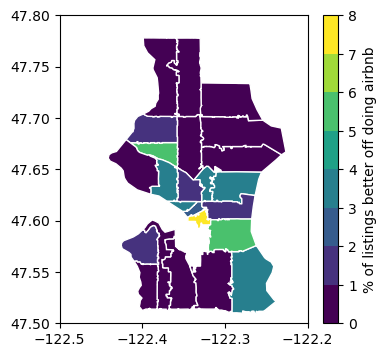

In [53]:
tmp = listings_filtered.groupby('zipcode').agg({'better_airbnb_high_end':'mean', 'id':'count'})
tmp.columns = ['better_airbnb_high_end', 'count']
print(tmp)
tmp = tmp[tmp['count'] > 5]
fig = zp.plot((tmp['better_airbnb_high_end']*100).to_dict(), 
              label='% of listings better off doing airbnb',
              vmin=0, vmax=8)

#### It looks pretty gloomy unless one is in the magic 98104 zipcode, which is in the central business area. Even that, only 17% are better off doing Airbnb (the color is over saturated). For most of the other regions, I need to make it to the top ~5%.

### Q2: How to become a good host of Airbnb?

Of course, the above esitmate might be over conservative, as I didn't take out anything from the rent, e.g. tax, empty period, maintainance fee etc. But the story would still hold that one needs to work hard to gain more money in Airbnb. Let's see what are the important ones.

In [5]:
def importance_plot(reg, cols, figsize=(10,20)):
    '''
      generate the importance plot
      input:
        reg: the regression model
        cols: name of columns in your X
      output:
        None
    '''
    tmp = pd.DataFrame(reg.best_estimator_.coef_, index=cols)
    tmp.reset_index(inplace=True)
    tmp.columns = ('feature','importance')
    plt.figure(figsize = figsize)
    sns.barplot(data = tmp,
                x = 'importance',
                y = 'feature',
                order = tmp.sort_values(by='importance').feature)

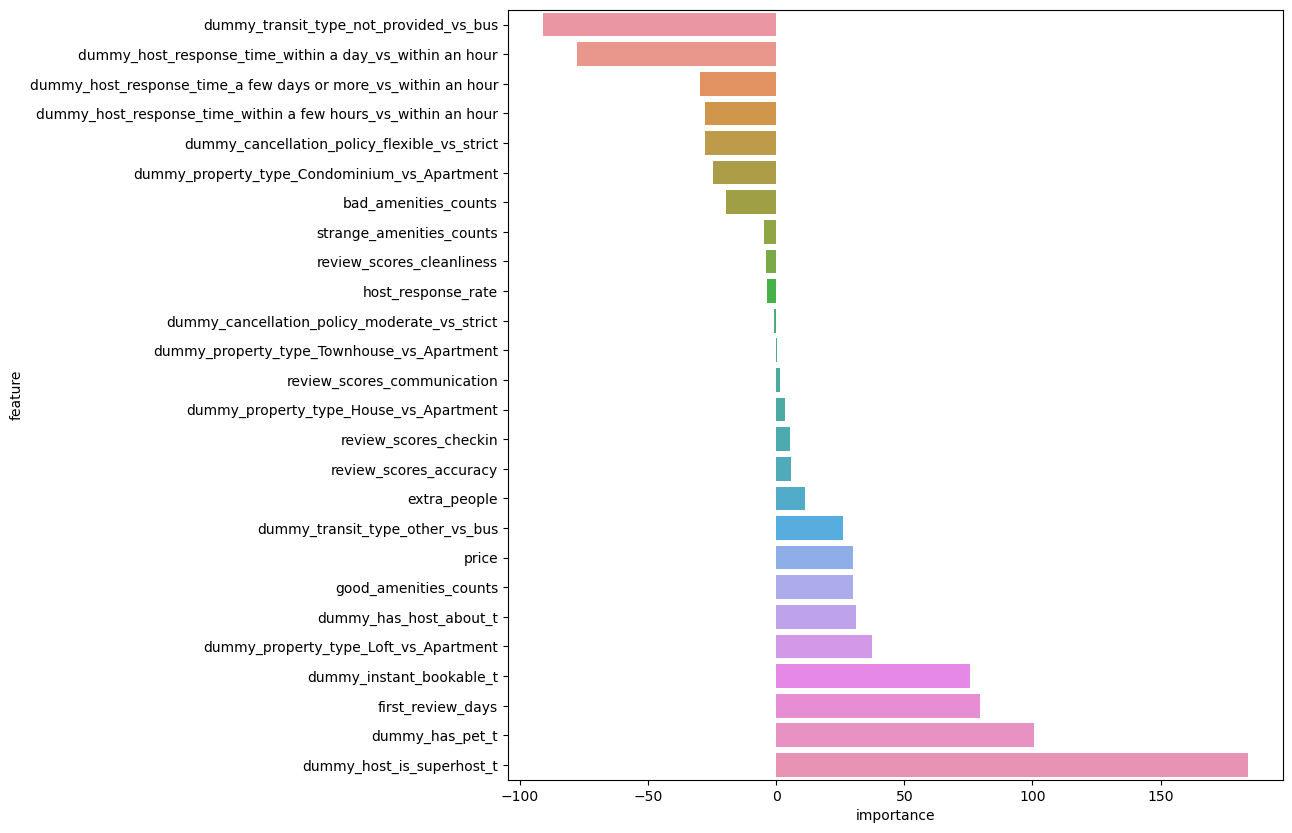

In [55]:
importance_plot(reg, cols, figsize=(10,10))

#### Some comments about the figure:
**Being a superhost** is the single most important thing to do. Somewhat surprisingly (or not), **having pets** is the second most important thing to increase my profit. The third is to **stay long enough in the market** (“first_review_days” feature means the number of days since the first review). I guess I need to be patient. On the other hand, some I can change quickly, for example, I can set my listing to “instantly bookable”, write something about myself (“dummy_has_host_about_t” feature), make my cancelation policy to be strict (“dummy_cancellation_policy_flexible_vs_strict” feature) and buy some good amenities, which are defined as “Hair Dryer”, “Laptop Friendly Workspace”, “Iron”, “Heating”, “24-Hour Check-in”, “Shampoo”, “Hangers”, “Essentials”, and, with **“Doorman”** the most important one in the good amenities list (not sure what that means though).

Some are actually strange. It seems people don’t rely too much on bus (“dummy_transit_type_other_vs_bus” feature), but it is very important to at least write something about transit method in the listing instead of leaving it empty (“dummy_transit_type_not_provided_vs_bus” feature). In addition, review scores aren’t that important in terms of sorting out the battle between Airbnb and renting.

The annoying part is that this figure also suggests having a response time within an hour is critically important, which brings us to Q3.

### Q3: Is there a particular season during the year that one should concentrate on?

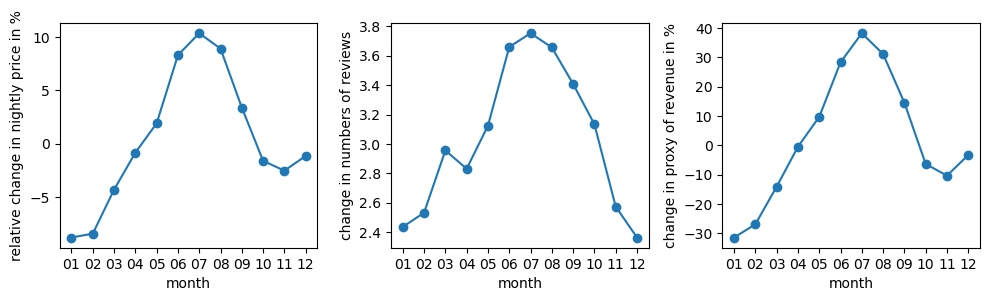

In [56]:
price_mean = month_price_relative.mean(axis=0)
review_mean = review_counts.mean(axis=0)
proxy_mean = (month_price_relative * review_counts).mean(axis=0)
fig = plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.plot(price_mean*100,'o-');plt.xlabel('month');plt.ylabel('relative change in nightly price in %')
plt.subplot(1,3,2)
plt.plot(review_mean,'o-');plt.xlabel('month');plt.ylabel('change in numbers of reviews')
plt.subplot(1,3,3)
plt.plot(proxy_mean*100,'o-');plt.xlabel('month');plt.ylabel('change in proxy of revenue in %')
fig.tight_layout()
plt.show()

#### It definately looks like one should focus more in the summer months, as a result of both an increase of nightly price and numbers of tourists.

## Conclusion:
#### Making Airbnb more profitable than long-term renting requires significant efforts. One needs to be among the top 5% to actually make it happen in most places. Certain things can help, for example, by being a super host, having a pet and reducing the response time. The data also suggest one should focus more on the summer months because of the increases in market nightly price and the number of tourists.